## Quant Job Cleaning & Analysis

Clean descriptions and salary ranges.
- descriptions to be used for word frequency count analysis
- salary ranges: analysis of median, min and max salaries

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re


# Path to the folder
folder = Path("data/country")

# Get all .csv files
csv_files = folder.glob("*.csv")

# Read and concat into one DataFrame
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Optional: Print shape or preview
print(f"Combined DataFrame shape: {df.shape}")
df_salary = df[~df.salary.isna()]
df_salary.to_csv('df_salary.csv')
df_salary.columns

Combined DataFrame shape: (8987, 28)


Index(['title', 'company_name', 'location', 'via', 'thumbnail', 'extensions',
       'description', 'job_id', 'posted_at', 'schedule_type', 'salary',
       'date_time', 'search_term', 'search_location', 'work_from_home',
       'share_link', 'job_highlights', 'apply_options', 'paid_time_off',
       'dental_coverage', 'health_insurance', 'qualifications', 'code',
       'country', 'country_long', 'year', 'ccTLD', 'notes'],
      dtype='object')

In [3]:
jobs_without_qual = len(df[df['qualifications'] == 'No degree mentioned'])
jobs_count = len(df)

jobs_without_qual, jobs_without_qual / jobs_count

16 / 4350

0.0036781609195402297

### US Jobs
All jobs 8,400 analysed that were listed for month of June 2025. 
4,350 jobs in US. 

Only 143 jobs did not mention a degree was required. 1.6% did not list degree requirements.

Unfortanetly the reality is most of these are outside US, with only 16 jobs of 4350 in US not listing a degreee. less than 0.4% of job listings. 

In [205]:
def extract_currency_prefix(s):
    if pd.isna(s) or not isinstance(s, str):
        return None
    
    # Remove commas and normalize dashes
    s = s.replace(',', '').replace('–', '-').strip()

    # Match prefix before first number (e.g., ₹, HK$, ZAR)
    match = re.match(r'^([^\d\s]+)', s)
    if match:
        return match.group(1).strip()
    else:
        return None

In [206]:
currency_prefixes = df['salary'].apply(extract_currency_prefix)
unique_currencies = currency_prefixes.dropna().unique()

print("Unique currency prefixes:")
print(unique_currencies)

Unique currency prefixes:
['€' 'SGD' '₹' 'MX$' 'HK$' '£' 'LKR' 'CA$' 'ZAR' 'TRY' 'A$' 'MYR' 'CHF'
 'KES']


In [207]:
currency_exchange_rates = {
    'USD': 1.00,
    '€': 1.08,       # Euro
    'SGD': 0.74,     # Singapore Dollar
    '₹': 0.012,      # Indian Rupee
    'MX$': 0.055,    # Mexican Peso
    'HK$': 0.13,     # Hong Kong Dollar
    '£': 1.27,       # British Pound
    'LKR': 0.0033,   # Sri Lankan Rupee
    'CA$': 0.73,     # Canadian Dollar
    'ZAR': 0.054,    # South African Rand
    'TRY': 0.031,    # Turkish Lira
    'A$': 0.66,      # Australian Dollar
    'MYR': 0.21,     # Malaysian Ringgit
    'CHF': 1.11,     # Swiss Franc
    'KES': 0.0077    # Kenyan Shilling
}

# Exchange rates to USD
exchange_rates = {
    'USD': 1.00,
    'EUR': 1.08,
    'SGD': 0.74,
    'INR': 0.012,
    'MXN': 0.055,
    'HKD': 0.13,
    'GBP': 1.27,
    'LKR': 0.0033,
    'CAD': 0.73,
    'ZAR': 0.054,
    'TRY': 0.031,
    'AUD': 0.66,
    'MYR': 0.21,
    'CHF': 1.11,
    'KES': 0.0077
}


prefix_to_iso = {
    '€': 'EUR',
    'SGD': 'SGD',
    '₹': 'INR',
    'MX$': 'MXN',
    'HK$': 'HKD',
    '£': 'GBP',
    'LKR': 'LKR',
    'CA$': 'CAD',
    'ZAR': 'ZAR',
    'TRY': 'TRY',
    'A$': 'AUD',
    'MYR': 'MYR',
    'CHF': 'CHF',
    'KES': 'KES'
}

In [208]:

def detect_currency(s):
    s_lower = s.lower()
    if '₹' in s or 'inr' in s_lower:
        return '₹'
    elif '€' in s or 'eur' in s_lower:
        return '€'
    elif 'sgd' in s_lower:
        return 'SGD'
    elif 'mx$' in s_lower or 'mxn' in s_lower:
        return 'MX$'
    elif 'hk$' in s_lower:
        return 'HK$'
    elif '£' in s or 'gbp' in s_lower:
        return '£'
    elif 'lkr' in s_lower:
        return 'LKR'
    elif 'ca$' in s_lower or 'cad' in s_lower:
        return 'CA$'
    elif 'zar' in s_lower:
        return 'ZAR'
    elif 'try' in s_lower:
        return 'TRY'
    elif 'a$' in s_lower or 'aud' in s_lower:
        return 'A$'
    elif 'myr' in s_lower:
        return 'MYR'
    elif 'chf' in s_lower:
        return 'CHF'
    elif 'kes' in s_lower:
        return 'KES'
    elif 'usd' in s_lower or '$' in s:  # fallback USD
        return 'USD'
    else:
        return 'USD'  # Default fallback


def clean_salary(s):
    if pd.isna(s) or not isinstance(s, str) or s.strip() == "":
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    original = s
    s = s.replace(',', '').replace('–', '-').lower()

    currency = detect_currency(original)
    fx = currency_exchange_rates.get(currency, 1.0)

    is_hourly = 'hour' in s
    is_daily = 'day' in s
    is_monthly = 'month' in s
    is_yearly = 'year' in s or not (is_hourly or is_daily or is_monthly)

    parts = re.findall(r'(\d+(?:\.\d+)?)([kKmM]?)', s)
    if not parts:
        return (np.nan, np.nan, np.nan, currency, np.nan, np.nan)

    def parse_amount(val, suffix):
        num = float(val)
        if suffix.lower() == 'k':
            num *= 1_000
        elif suffix.lower() == 'm':
            num *= 1_000_000
        return num

    try:
        numbers = [parse_amount(v, sfx) for v, sfx in parts]
    except Exception:
        return (np.nan, np.nan, np.nan, currency, np.nan, np.nan)

    if not numbers:
        return (np.nan, np.nan, np.nan, currency, np.nan, np.nan)

    min_salary_orig = min(numbers)
    max_salary_orig = max(numbers)
    avg_salary_orig = np.mean(numbers)

    # Normalize to annual
    multiplier = 1
    if is_hourly:
        multiplier = 40 * 52
    elif is_daily:
        multiplier = 336
    elif is_monthly:
        multiplier = 12

    min_salary_orig *= multiplier
    max_salary_orig *= multiplier
    avg_salary_orig *= multiplier

    # Convert to USD
    min_salary_usd = min_salary_orig * fx
    max_salary_usd = max_salary_orig * fx
    avg_salary_usd = avg_salary_orig * fx

    return (
        min_salary_usd,
        max_salary_usd,
        avg_salary_usd,
        currency,
        min_salary_orig,
        max_salary_orig
    )


In [209]:
df[['min_salary_usd', 'max_salary_usd', 'avg_salary_usd', 
    'currency', 'min_salary_orig', 'max_salary_orig']] = df['salary'].apply(
    lambda s: pd.Series(clean_salary(s))
)

In [210]:
# Sort by clean_salary in descending order
df_sorted = df.sort_values(by='avg_salary_usd', ascending=True)

# Preview
print(df_sorted[['salary', 
    'currency', 'min_salary_usd', 'max_salary_usd', 'avg_salary_usd']].head(50))

                            salary currency  min_salary_usd  max_salary_usd  \
6745                     £1 a year        £         1.27000         1.27000   
8438            ₹120B–₹150B a year        ₹         1.44000         1.80000   
692                  SGD 1 a month      SGD         8.88000         8.88000   
600                  SGD 1 a month      SGD         8.88000         8.88000   
7612                  CA$75 a year      CA$        54.75000        54.75000   
83                €100–€125 a year        €       108.00000       135.00000   
6455        £100.00–£112.50 a year        £       127.00000       142.87500   
6339        £100.00–£112.50 a year        £       127.00000       142.87500   
1173               ₹40–₹50 an hour        ₹       998.40000      1248.00000   
8661                 MYR 6 an hour      MYR      2620.80000      2620.80000   
1522             ₹15K–₹22K a month        ₹      2160.00000      3168.00000   
1491                  ₹20K a month        ₹      288

<Axes: >

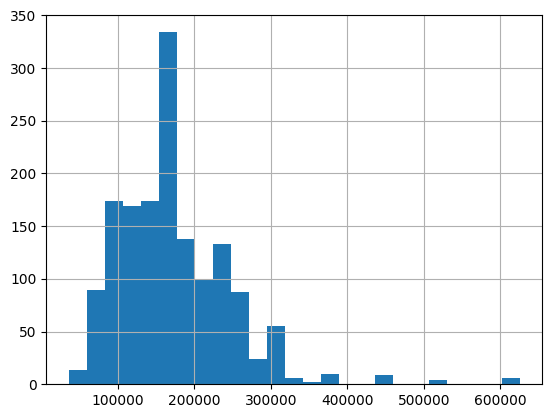

In [211]:
df[df.currency.isin(['USD'])]['avg_salary_usd'].hist(bins=25)

In [212]:
df[df.currency.isin(['USD'])].to_csv('avg_salary_usd.csv')

In [213]:
search_term_to_role = {
    'Quantitative Researcher': 'Quantitative Researcher (also Quantitative Analyst)',
    'Quantitative Analyst': 'Quantitative Researcher (also Quantitative Analyst)',
    
    'Quantitative Trader': 'Quantitative Trader (also Algorithmic Trader)',
    'Algorithmic Trader': 'Quantitative Trader (also Algorithmic Trader)',
    'Trader': 'Quantitative Trader (also Algorithmic Trader)',
    'Energy Trader': 'Quantitative Trader (also Algorithmic Trader)',
    'Power Trader': 'Quantitative Trader (also Algorithmic Trader)',

    'Quantitative Developer': 'Quantitative Developer (also Quantitative Software Engineer)',
    'Quantitative Software Engineer': 'Quantitative Developer (also Quantitative Software Engineer)',

    'Model Validation Quantitative Analyst': 'Model Validation Quantitative Analyst',
    'Model Validation Analyst': 'Model Validation Quantitative Analyst',

    'Quantitative Risk Analyst': 'Quantitative Risk Analyst',
    'Energy Analyst': 'Quantitative Risk Analyst',

    'Quantitative Portfolio Manager': 'Quantitative Portfolio /Investment/Asset Manager',
    'Quantitative Investment Manager': 'Quantitative Portfolio /Investment/Asset Manager',
    'Quantitative Asset Manager': 'Quantitative Portfolio /Investment/Asset Manager',

    'Quantitative Strategist': 'Quantitative Strategist (Strat)',

    'Financial Engineer': 'Financial Engineer (also Quantitative Pricing Analyst or Sell-Side Quant)',
    'Quantitative Pricing Analyst': 'Financial Engineer (also Quantitative Pricing Analyst or Sell-Side Quant)'
}


In [214]:
df['role'] = df['search_term'].map(search_term_to_role)

In [217]:
percentiles = df['avg_salary_usd'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
percentiles, df['avg_salary_usd'].mean()

(0.05     31080.0
 0.25     96000.0
 0.50    150000.0
 0.75    200000.0
 0.95    300000.0
 Name: avg_salary_usd, dtype: float64,
 np.float64(154324.03468288307))

In [171]:
percentiles = df.groupby('role')['avg_salary_usd'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]).unstack()
percentiles.columns = ['5th', '25th', '50th', '75th', '95th']

In [172]:
percentiles

,5th,25th,50th,75th,95th
role,,,,,
Financial Engineer (also Quantitative Pricing Analyst or Sell-Side Quant),75660.0,110000.0,143100.00,197500.0,255775.0
Model Validation Quantitative Analyst,87600.0,107666.5,130492.25,175000.0,300000.0
Quantitative Developer (also Quantitative Software Engineer),5760.0,90000.0,149250.00,175000.0,266500.0
Quantitative Portfolio /Investment/Asset Manager,60000.0,150000.0,175000.00,212500.0,275000.0
Quantitative Researcher (also Quantitative Analyst),39992.0,109200.0,171600.00,225000.0,300000.0
Quantitative Risk Analyst,56178.0,96000.0,102000.00,157500.0,300000.0
Quantitative Strategist (Strat),102320.0,150000.0,165000.00,184000.0,240000.0
Quantitative Trader (also Algorithmic Trader),26640.0,60000.0,109200.00,187500.0,251250.0


In [173]:
# Step 1: Count job postings per role
role_counts = df[~df.avg_salary_usd.isna()]['role'].value_counts()
sum(role_counts)

1984

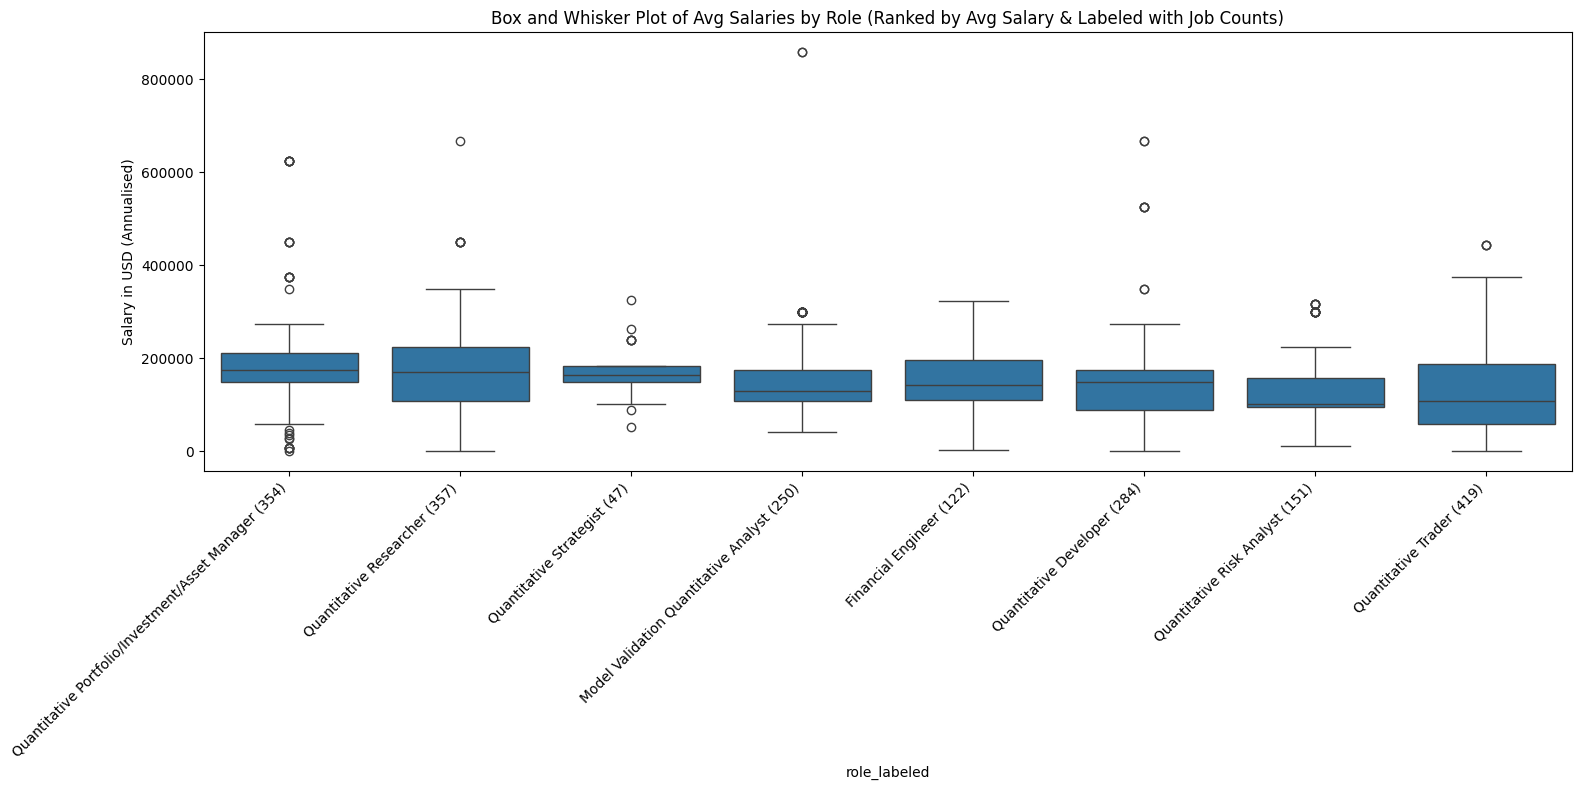

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Count job postings per role
role_counts = df[~df.avg_salary_usd.isna()]['role'].value_counts()

# Step 2: Compute average salary per role
cleaned_roles = [re.sub(r"\s*\(.*?\)", "", role) for role in role_salary_ranking.index]

role_salary_ranking = df.groupby('role')['avg_salary_usd'].mean().sort_values(ascending=False)

# Step 2: Create role labels with job counts
role_labels = [f"{cleaned} ({role_counts[original]})" for cleaned, original in zip(cleaned_roles, role_salary_ranking.index)]

# Step 4: Create a mapping from original role to labeled role
role_label_map = dict(zip(role_salary_ranking.index, role_labels))
df['role_labeled'] = df['role'].map(role_label_map)

# Step 5: Set categorical order for plotting
df['role_labeled'] = pd.Categorical(df['role_labeled'], categories=role_labels, ordered=True)

# Step 6: Plot
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='role_labeled', y='avg_salary_usd')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Salary in USD (Annualised)")
plt.title("Box and Whisker Plot of Avg Salaries by Role (Ranked by Avg Salary & Labeled with Job Counts)")
plt.tight_layout()
plt.show()



In [223]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
import textwrap
import matplotlib.ticker as mtick

# 1. Compute percentiles
percentiles = (
    df.groupby('role')['avg_salary_usd']
      .quantile([0.05, 0.25, 0.5, 0.75, 0.95])
      .unstack()
)
percentiles.columns = ['5th', '25th', '50th', '75th', '95th']

# 2. Sort by median descending
median_rank = percentiles['50th'].sort_values(ascending=False)

# 3. Count postings per role
role_counts = df[~df.avg_salary_usd.isna()]['role'].value_counts()

wrap_width = 28
role_labels = []

for i, role in enumerate(median_rank.index, start=1):
    # Remove anything in brackets from role name
    clean_name = re.sub(r"\s*\(.*?\)", "", role)
    
    count = role_counts.get(role, 0)
    median_val = median_rank.loc[role]

    # Wrap only the role name (with rank prefix)
    role_line = f"{i}. {clean_name}"
    wrapped_lines = textwrap.wrap(role_line, width=wrap_width)

    # Create the final line with count and salary
    final_line = f"({count}) – ${median_val:,.0f}"

    # Combine all lines
    full_label = "\n".join(wrapped_lines + [final_line])
    role_labels.append(full_label)

# 5. Map back onto df
label_map = dict(zip(median_rank.index, role_labels))
df['role_labeled'] = df['role'].map(label_map)

# 6. Make categorical with ordered labels
df['role_labeled'] = pd.Categorical(df['role_labeled'], categories=role_labels, ordered=True)



# 7. Plot horizontal boxplot
plt.figure(figsize=(6, 8))
ax = sns.boxplot(
    data=df,
    y='role_labeled',
    x='avg_salary_usd',
    orient='h',
    width=0.5,  # Decrease for thinner boxes, increase (up to 1.0) for thicker
    fliersize=2,  # <- Smaller dots
    flierprops=dict(marker='o', color='gray', alpha=0.5),  # Light grey, semi-transparent
    color='#0cc0df',
    # linewidth=0.8,              # thinner box lines
    # boxprops=dict(linewidth=0.8),
    # whiskerprops=dict(linewidth=0.8),
    # capprops=dict(linewidth=0.8),
    # medianprops=dict(linewidth=1.2)
)

# Format x-axis as USD currency with commas and $ sign
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.xlabel("Salary in USD (Annualised)")
plt.ylabel("")  
# plt.title("Salary Distribution by Role — Ranked by Median (with Counts)")
plt.tight_layout()
# plt.show()

# Save the figure as a high-quality PNG
plt.savefig('salary_box_and_whiskers_plot.png', dpi=300, bbox_inches='tight')  # dpi=300 is high-res, bbox_inches trims whitespace
plt.close()  # optional, to close the plot and free memory


In [229]:
import pandas as pd
import re
from collections import Counter

# Assume your dataframe is called df and descriptions are in 'description' column
texts = df['description'].dropna().str.lower()  # lowercase and drop missing

# Join all descriptions into one big string
all_text = ' '.join(texts)

# Simple tokenization: split by non-alphabetic characters
words = re.findall(r'\b[a-z]{2,}\b', all_text)  # words with length >= 2

# Count frequencies
word_freq = Counter(words)

# Convert to DataFrame for nicer display/sorting
freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

freq_df

freq_df.to_csv('quantitative finance job description frequency count.csv')

In [228]:
freq_df.head(50)

,word,count
38,and,229702
21,to,119209
1,the,101835
199,of,85174
7,in,76564
84,with,56916
12,for,44542
236,or,36202
229,is,30924
637,trading,29359


In [15]:
import pandas as pd
import re
from collections import defaultdict

# Load your description DataFrame
# Assume it's already called df and has a 'description' column
df['description'] = df['description'].fillna('').str.lower()

# Load your list of skills/phrases
skills_df = pd.read_csv('quant_finance_core_skills.csv', header=None)
skills = skills_df[0].str.lower().str.strip().tolist()  # normalize and clean

# Initialize counter
skill_counts = defaultdict(int)

# Search each description
for desc in df['description']:
    for skill in skills:
        # Escape special regex characters in skill (in case of phrases like 'C++' or 'R&D')
        pattern = re.escape(skill)
        # Use word boundaries only if it's a single word
        if ' ' not in skill:
            pattern = r'\b' + pattern + r'\b'
        matches = re.findall(pattern, desc)
        skill_counts[skill] += len(matches)

# Convert to DataFrame and sort
skill_freq_df = pd.DataFrame(list(skill_counts.items()), columns=['skill', 'count'])
skill_freq_df = skill_freq_df.sort_values(by='count', ascending=False).reset_index(drop=True)

print(skill_freq_df.head(50))  # Top 20 matching skills
skill_freq_df.to_csv('quant_skills.csv')

                             skill  count
0                          trading  29359
1                         research  14000
2                         analysis  10661
3                  risk management   6825
4                      programming   5022
5                      mathematics   4245
6                       statistics   3768
7                          pricing   3305
8                 machine learning   3038
9                     optimization   2245
10                model validation   1983
11                     derivatives   1847
12                   data analysis   1695
13           quantitative analysis   1457
14                     credit risk   1208
15            statistical analysis    839
16                     backtesting    749
17                           linux    698
18                  stress testing    638
19                      regression    552
20          high-frequency trading    538
21                    econometrics    467
22            strategy development

In [11]:
import pandas as pd
import re
from collections import defaultdict

# Load your description DataFrame
# Assume it's already called df and has a 'description' column
df['description'] = df['description'].fillna('').str.lower()

# Load your list of skills/phrases
skills_df = pd.read_csv('quant_finance_libraries.csv', header=None)
skills = skills_df[0].str.lower().str.strip().tolist()  # normalize and clean

# Initialize counter
skill_counts = defaultdict(int)

# Search each description
for desc in df['description']:
    for skill in skills:
        # Escape special regex characters in skill (in case of phrases like 'C++' or 'R&D')
        pattern = re.escape(skill)
        # Use word boundaries only if it's a single word
        if ' ' not in skill:
            pattern = r'\b' + pattern + r'\b'
        matches = re.findall(pattern, desc)
        skill_counts[skill] += len(matches)

# Convert to DataFrame and sort
skill_freq_df = pd.DataFrame(list(skill_counts.items()), columns=['skill', 'count'])
skill_freq_df = skill_freq_df.sort_values(by='count', ascending=False).reset_index(drop=True)

print(skill_freq_df.head(20))  # Top 20 matching skills
skill_freq_df.to_csv('libraries.csv')

           skill  count
0         pandas    463
1          numpy    417
2     tensorflow    198
3          scipy    170
4        pytorch    169
5          spark    148
6   scikit-learn    138
7         hadoop     88
8        xgboost     55
9          keras     46
10    matplotlib     44
11      lightgbm     38
12    backtrader     19
13      quantlib     18
14   statsmodels     14
15       zipline      4
16        ta-lib      4
17          pymc      3
18       blotter      2
19            bt      1


In [14]:
import pandas as pd
import re
from collections import defaultdict

# Load your description DataFrame
# Assume it's already called df and has a 'description' column
df['description'] = df['description'].fillna('').str.lower()

# Load your list of skills/phrases
skills_df = pd.read_csv('quant_finance_programming_languages.csv', header=None)
skills = skills_df[0].str.lower().str.strip().tolist()  # normalize and clean

# Initialize counter
skill_counts = defaultdict(int)

# Search each description
for desc in df['description']:
    for skill in skills:
        # Escape special regex characters in skill (in case of phrases like 'C++' or 'R&D')
        pattern = re.escape(skill)
        # Use word boundaries only if it's a single word
        if ' ' not in skill:
            pattern = r'\b' + pattern + r'\b'
        matches = re.findall(pattern, desc)
        skill_counts[skill] += len(matches)

# Convert to DataFrame and sort
skill_freq_df = pd.DataFrame(list(skill_counts.items()), columns=['skill', 'count'])
skill_freq_df = skill_freq_df.sort_values(by='count', ascending=False).reset_index(drop=True)

print(skill_freq_df.head(20))  # Top 20 matching skills
skill_freq_df.to_csv('langauges.csv')

     skill  count
0   python   7069
1      sql   2328
2        r   1976
3     java   1301
4      sas    701
5   matlab    638
6    shell    634
7     rust    531
8      kdb    424
9      vba    406
10      go    289
11    bash     77
12     c++     51
13   scala     42
14   julia     25
15    perl     11
16      c#      1
